In [1]:
# preprocess of mouse brain reference data and spatial proteomics
# Yuan
# 20241125
# Fig. 4

In [5]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats
import warnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")
import cell2location

plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

Global seed set to 0


# Preprocess and visualization of cell-type proteomics data
- Fig. 4a

         Falling back to preprocessing with `sc.pp.pca` and default params.


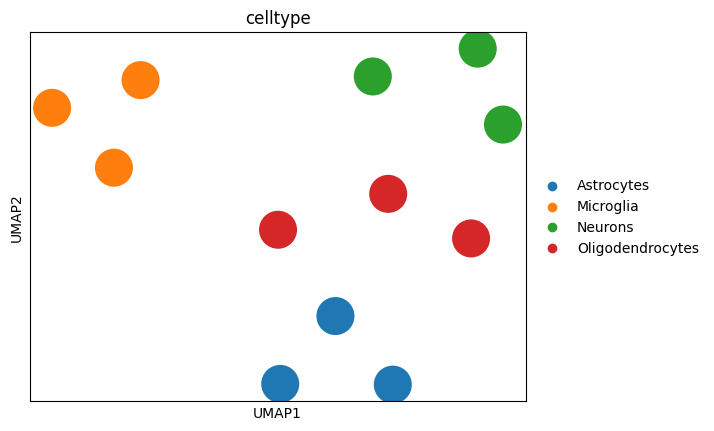

In [6]:
# Preprocess of 2015 Mouse Brain MS-base single-cell-type proteomics data
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MouseBrain2022/")

sc_adata_df = pd.read_csv("sc_adata_df.csv",sep="\t") #10883 * 13
sc_adata_df.index = sc_adata_df["pid"]

sc_meta_df = pd.read_csv("sc_adata_meta.csv",sep="\t",index_col=0) #10883 * 2
sc_meta_df = sc_meta_df[sc_meta_df.index.isin(sc_adata_df.columns)] # keep ordered meta_df

sc_adata_df = sc_adata_df[sc_meta_df.index] #order by meta_df

# add var annotation
var_df = pd.read_csv("pid_gene_17207_mmu.csv")
sc_var_df = pd.DataFrame(index=sc_adata_df.index)

sc_var_df = pd.merge(sc_var_df,var_df,on="pid",how="left")
sc_var_df.index = sc_var_df["pid"]

sc_adata = sc.AnnData(X = csr_matrix(sc_adata_df.T),obs = sc_meta_df,var=sc_var_df)
# sc_adata.write_h5ad("MouseBrain2022_CellType4_impute.h5ad")

# vis with UMAP
sc.pp.normalize_total(sc_adata)
sc.pp.log1p(sc_adata)

sc.pp.neighbors(sc_adata, n_pcs=10, n_neighbors=5)
sc.tl.umap(sc_adata)

sc.pl.umap(sc_adata, color=["celltype"], size=3000, save="_MouseBrain2022_impute_ct4_10734.pdf")

# save umap table
# NOT used
# umap_values = sc_adata.obsm["X_umap"]
# celltype_obs = sc_adata.obs["celltype"]
# df = pd.DataFrame(umap_values, columns=["UMAP1", "UMAP2"])
# df["celltype"] = celltype_obs.values
# df.to_csv("figures/umap_MouseBrain2022_impute_ct4_10734.csv")

# Preprocess and visualization of tonsil spatial proteomics data
# - Fig. 4b



In [7]:
# create spatial proteomics data
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MouseBrain2022/00_raw")

sp_adata_df = pd.read_csv("sp_adata.csv",sep="\t") #10883 * 13
sp_adata_df.index = sp_adata_df["pid"]

sp_meta_df = pd.read_csv("sp_adata_meta.csv",sep="\t",index_col=0) #10883 * 2
sp_meta_df = sp_meta_df[sp_meta_df.index.isin(sp_adata_df.columns)] # keep ordered meta_df

sp_adata_df = sp_adata_df[sp_meta_df.index] #order by meta_df

# # add var annotation
var_df = pd.read_csv("pid_gene_17207_mmu.csv")
sp_var_df = pd.DataFrame(index=sp_adata_df.index)

sp_var_df = pd.merge(sp_var_df,var_df,on="pid",how="left")
sp_var_df.index = sp_var_df["pid"]

sp_adata = sc.AnnData(X = csr_matrix(sp_adata_df.T),obs = sp_meta_df,var=sp_var_df)
sp_adata.obsm["spatial"] = np.array(sp_adata.obs[["X","Y"]])

sp_adata.write_h5ad("MouseBrain2022_spot208_impute.h5ad")

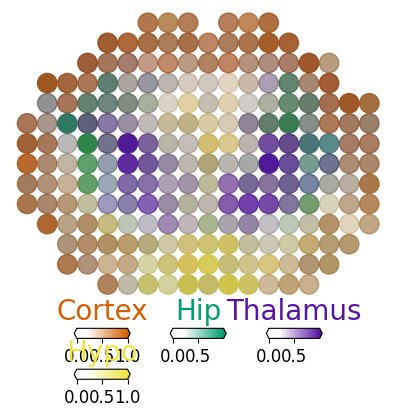

In [14]:
# visualization of regional markers
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MouseBrain2022/00_raw/")
scaler = MinMaxScaler(feature_range=(0, 1))

sp_adata = sc.read_h5ad("MouseBrain2022_spot208_impute.h5ad")
sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

pids = ["Q9JJV5", "P97441","Q8CC35"] #Cortex
sp_adata.obs["Cortex"]= np.mean(sp_adata.to_df()[pids],axis=1)
   
pids = ["P51830", "Q8VHW2","Q0VE82","P23818","Q61097","P62748","Q9QVP9","Q3UH99"] #Hip
# pids = ["Q8VHW2","P23818"] #Hip
sp_adata.obs["Hip"]= np.mean(sp_adata.to_df()[pids],axis=1)            

pids = ["Q3TVA9", "P28867","Q91YE8"] #Tha 
# pids = ["Q3TVA9", "Q91YE8"] #Tha
sp_adata.obs["Thalamus"]= np.mean(sp_adata.to_df()[pids],axis=1)            

pids = ["P12961", "Q99P58","Q9QXV0"] #Hypo
# pids = ["P12961", "Q9QXV0"] #Hypo
sp_adata.obs["Hypo"]= np.mean(sp_adata.to_df()[pids],axis=1)            

sp_adata.obs[["Cortex", "Hip", "Thalamus", "Hypo"]]= scaler.fit_transform(sp_adata.obs[["Cortex", "Hip", "Thalamus", "Hypo"]])
# show the co-localization of interacted cells
plt = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=["Cortex", "Hip", "Thalamus", "Hypo"],
                                     color=["Cortex", "Hip", "Thalamus", "Hypo"],circle_diameter=14.0,reorder_cmap=[1,3,4,0],max_color_quantile=1)
plt.savefig("figures/MouseBrain_region4_distribution.pdf")
plt.show()

# sp_adata.obs[["Cortex", "Hip", "Thalamus", "Hypo"]].to_csv("figures/region4_distribution.csv")

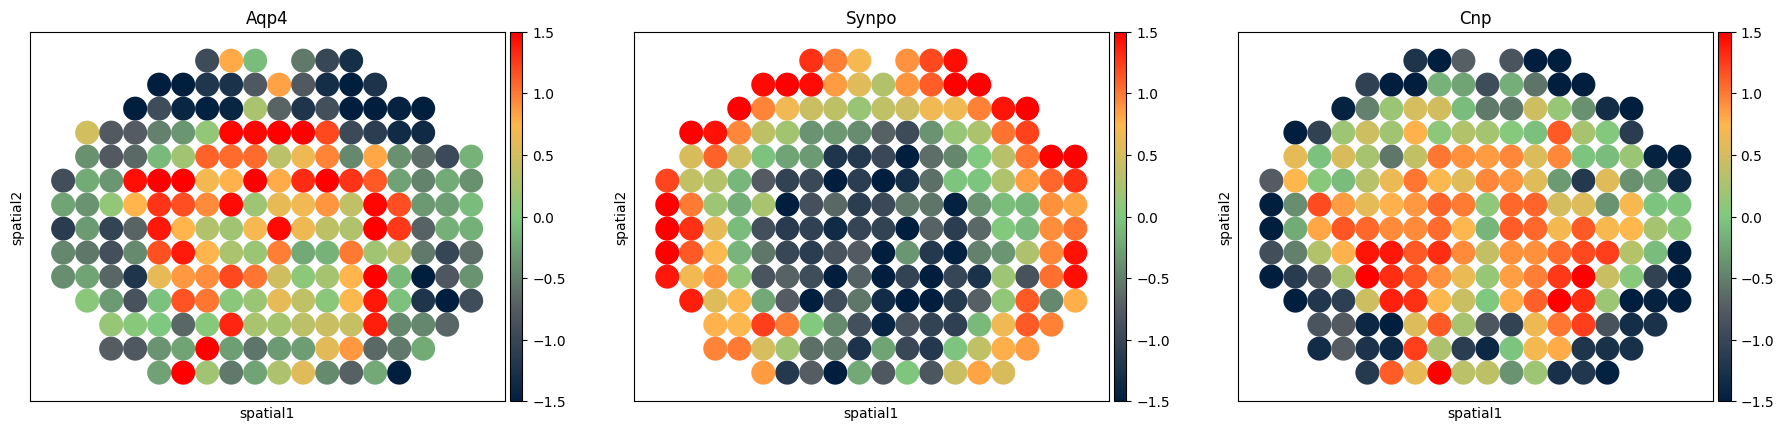

In [13]:
# # visualization of known cell-type specific markers
# Fig. 3c
scaler = MinMaxScaler(feature_range=(0, 1))
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MouseBrain2022/00_raw/")

colors = ['#001f3f', '#545b62', '#7fc97f', '#ffb74d', 'red']
my_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)

pids = ["P55088","Q8CC35","P16330"]
pids_gene = ["Aqp4","Synpo","Cnp"] # ["Astrocytes","Neurons","Oligodendrocytes"]

sp_adata = sc.read_h5ad("MouseBrain2022_spot208_impute.h5ad")
sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)
sc.pp.scale(sp_adata)

sc.pl.spatial(sp_adata, spot_size=1,color=pids,cmap=my_cmap,vmin=-1.5,vmax=1.5,title=pids_gene,save="_ct3_known_markers.pdf")


In [12]:
# Keep intersected proteins, for comparison of deconvolution methods
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MouseBrain2022/00_raw")
sc_adata = sc.read_h5ad("MouseBrain2022_CellType4_impute.h5ad")
sp_adata = sc.read_h5ad("MouseBrain2022_spot208_impute.h5ad")

intersected_pid = np.intersect1d(sc_adata.var_names,sp_adata.var_names)
print(intersected_pid.shape) # 4351

# save for benchmark study
sc_adata = sc_adata[:,intersected_pid].copy()
sp_adata = sp_adata[:,intersected_pid].copy()

sc_adata.write_h5ad("for_benchmark/MouseBrain2022_ct4_4351.h5ad")
sp_adata.write_h5ad("for_benchmark/MouseBrain2022_spot208_4351.h5ad")

# for benchmark 
sc_adata.to_df().T.to_csv("for_benchmark/MouseBrain2022_ct4_expression.csv")
sc_adata.obs.to_csv("for_benchmark/MouseBrain2022_ct4_meta.csv")
sp_adata.to_df().T.to_csv("for_benchmark/MouseBrain2022_spot208_expression.csv")
sp_adata.obs[["X","Y"]].to_csv("for_benchmark/MouseBrain2022_spot208_meta.csv")

(4351,)
